In [22]:
import sys
import os
# Local imports
src_dir = os.path.abspath('../')
os.chdir(src_dir)
sys.path.append(src_dir)
from src.config import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import warnings
import itertools
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
import itertools
from datetime import datetime

## Funs

In [17]:
def set_notebook_options(matplotlib_params_dct={}, plt_style='fivethirtyeight'):
    # Set matplotlib params
    default_matplotlib_params_dct = {'axes.labelsize': 14,
                                    'xtick.labelsize': 12,
                                    'ytick.labelsize': 12,
                                    'text.color': 'k'}
    
    matplotlib_params_dct = default_matplotlib_params_dct | matplotlib_params_dct
    for key, value in matplotlib_params_dct.items():
        matplotlib.rcParams[key] = value
    # Plt style
    plt.style.use(plt_style)
    # Seaborn style
    sns.set_style("whitegrid")

In [4]:
class DataLoader:
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir
        self.data = None
        self.loaded_data_dct = {}
    
    def load_data(self, data_file, *args, **kwargs):
        if data_file == 'co2_data':
            self.data = sm.datasets.co2.load_pandas().data
        else:  
            data_path = os.path.join(self.data_dir, data_file)
            self.data = pd.read_csv(data_path, *args, **kwargs)
        
        self.loaded_data_dct[data_file] = self.data

        return self.data

In [7]:
class DataProcessor:
    def __init__(self, data=None):
        self.data = data
    
    def set_dt_index(self, dt_col, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data[dt_col] = pd.to_datetime(data[dt_col])
        data = data.set_index(dt_col)
        data = data.sort_index()
        if inplace:
            self.data = data
        return data
    
    def sort_index(self, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.sort_index()
        if inplace:
            self.data = data
        return data
    
    def rename_dt_index(self, new_name='', data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data.index.names = [new_name]
        if inplace:
            self.data = data
        return data

    def rename_df_columns(self, col_name_map={}, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.rename(columns=col_name_map)
        if inplace:
            self.data = data
        return data

    def drop(self, data=None, inplace=False, *args, **kwargs):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.drop(*args, **kwargs)
        if inplace:
            self.data = data
        return data
    
    def select_columns(self, columns=[], data=None, inplace=False, *args, **kwargs):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data[columns]
        if inplace:
            self.data = data
        return data

    def preprocess_data(self):
        pass

In [23]:
def train_test_ts_split(data, train_size=0.8, split_date=None):
    data = data.sort_index()
    data_dates = data.index.unique()
    
    if split_date is None:
        split_date = data_dates[int(len(data_dates) * train_size)]
    split_date = pd.to_datetime(split_date)
    
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    
    return train, test

In [18]:
set_notebook_options()

## CO2 Data

In [8]:
df = DataLoader().load_data('co2_data')
dp = DataProcessor(df)
dp.sort_index(inplace=False)
dp.rename_dt_index('dt', inplace=True)
dp.rename_df_columns({'co2': 'y'}, inplace=True)
co2_df = dp.data

In [9]:
# The 'MS' string groups the data in buckets by start of the month
co2_df = dp.set_dt_index('dt', data=co2_df.resample('MS').mean().reset_index())
# The term bfill means that we use the value before filling in missing values
co2_df = co2_df.fillna(co2_df.bfill())

In [15]:
import seaborn as sns
sns.set_style("whitegrid")

<Axes: xlabel='dt'>

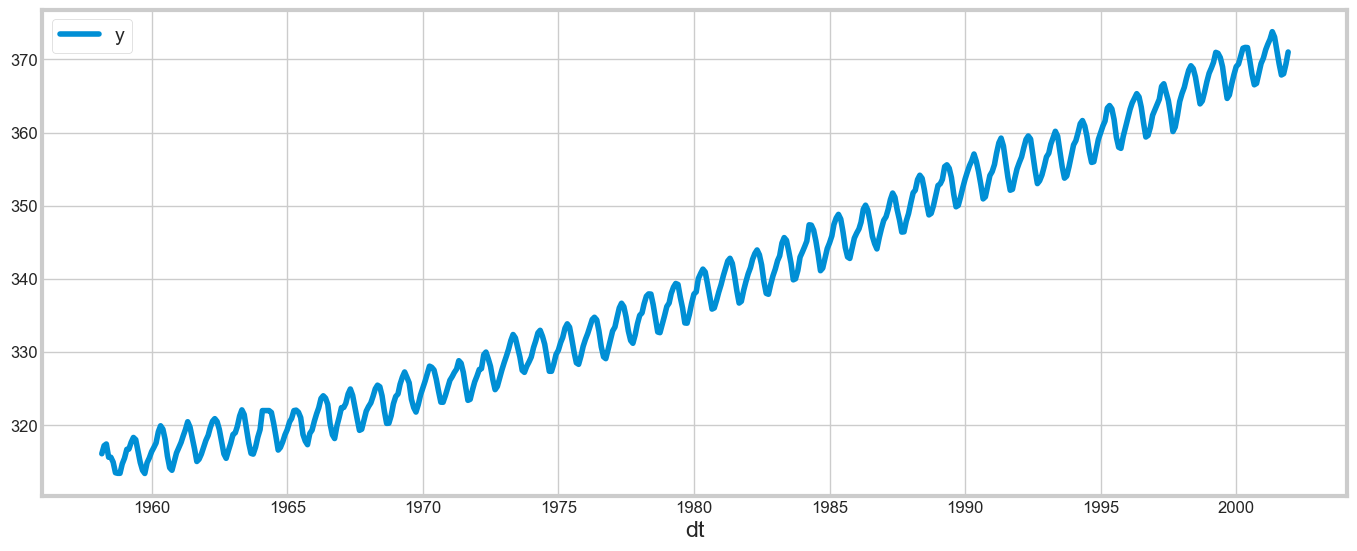

In [21]:
# Plot the data in a nice plot
plt.figure(figsize=(15, 6))
sns.lineplot(co2_df)

In [8]:
train_size = 0.8
split_year_str = str(co2_df.index.year.unique()[int(co2_df.index.year.nunique() * train_size)])
split_date_dt = pd.to_datetime(datetime.strptime(split_year_str, '%Y').date())

train = co2_df.loc[co2_df.index < split_date_dt]
test = co2_df.loc[co2_df.index >= split_date_dt]

In [9]:
import warnings
import itertools
from tqdm.notebook import tqdm

train_metric = 'mse'

# Define the parameter grids
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s_values = [12]

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

tscv = TimeSeriesSplit(n_splits=5)

warnings.filterwarnings("ignore")

best_metric_value= np.inf
best_params = None
best_model = None

# Perform a parameter grid search
for params in tqdm(param_grid):
    param, param_seasonal = params[:3], params[3:]
    cv_metrics = []
    # Perfomr cross-validation
    for train_idx, val_idx in tscv.split(co2_df):
        # Obtain the train and test sets
        train = co2_df.iloc[train_idx]
        test = co2_df.iloc[val_idx]
        # Train the model
        try:
            sarimax_model = sm.tsa.statespace.SARIMAX(train,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
            sarimax_model_fit = sarimax_model.fit()
        except:
            continue
        # Make predictions
        y_pred = sarimax_model_fit.get_prediction(start=test.index.min(), end=test.index.max(), dynamic=False).predicted_mean
        y_pred.index.name = 'dt'
        y_pred = dp.set_dt_index('dt', data=y_pred.reset_index())
        y_pred = dp.rename_df_columns({'predicted_mean': 'y'}, data=y_pred)
        # Calculate the metric
        if train_metric == 'aic':
            train_metric_val = sarimax_model_fit.aic
        elif train_metric == 'mse':
            train_metric_val = mean_squared_error(test, y_pred)
        elif train_metric == 'rmse':
            train_metric_val = np.sqrtr(mean_squared_error(test, y_pred))
        
        cv_metrics.append(train_metric_val)
    # Aggregate the metrics
    cv_metrics_agg = np.mean(cv_metrics)
    # Update the best model
    if cv_metrics_agg < best_metric_value:
        best_metric_value = cv_metrics_agg
        best_params = params
        best_model = sarimax_model
    

  0%|          | 0/324 [00:00<?, ?it/s]

In [39]:
class SarimaxModel:

    def __init__(self, tscv_splits=2):
        self.best_metric_value= np.inf
        self._time_series_splitter = TimeSeriesSplit(n_splits=tscv_splits)
        self.best_cv_params = None
        self.best_cv_model = None
        self.model = None
        self.model_fit = None
    
    def train_test_split(self, data, train_size=0.8, split_date=None):
        return train_test_ts_split(data, train_size=train_size, split_date=split_date)
    
    def fit_best_cv_model(self, data, train_test_split=True, param_grid=None, train_metric='mse', tscv_splits=5):
        if (self.best_cv_params is None) and (param_grid is None):
            raise ValueError('No parameter grid provided!')
        elif self.best_cv_params is None:
            self.perform_gridsearch_cv(data, param_grid, train_metric=train_metric, tscv_splits=tscv_splits)
        param, param_seasonal = self.best_cv_params[:3], self.best_cv_params[3:]
        if train_test_split:
            train, test = self.train_test_split(data)
        else:
            train = data
        try:
            self.model = sm.tsa.statespace.SARIMAX(train,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=True,
                                                    enforce_invertibility=True)
            self.model_fit = self.model.fit()
        except:
            raise ValueError('Model fitting failed!')
        if train_test_split:
            # Make predictions
            y_pred = self.get_model_fit_predictions(self.model_fit, start=test.index.min(), end=test.index.max(), dynamic=False)
            # Calculate the metric
            train_metric_val = self.calc_metric(test, y_pred, model=self.model_fit, metric=train_metric)
            print(f"Model trained on {train.index.min()} to {train.index.max()} and tested on {test.index.min()} to {test.index.max()}")
            print(f"Model obtained {train_metric_val:.2f} {train_metric} on the test set!")
            return self.model, y_pred, train_metric_val
        else:
            return self.model

    def perform_gridsearch_cv(self, data, param_grid, train_metric='mse', tscv_splits=5):
        # if time_series_splitter is none initialize it
        if tscv_splits is not None: 
            self.time_series_splitter = tscv_splits

        warnings.filterwarnings("ignore")
        print(f"Started GridSearchCV...")
        # Perform a parameter grid search
        for params in tqdm(param_grid):
            param, param_seasonal = params[:3], params[3:]
            cv_metrics = []
            # Perfomr cross-validation
            for train_idx, val_idx in self.time_series_splitter.split(data):
                # Obtain the train and test sets
                train = data.iloc[train_idx]
                test = data.iloc[val_idx]
                # Train the model
                try:
                    sarimax_model = sm.tsa.statespace.SARIMAX(train,
                                                            order=param,
                                                            seasonal_order=param_seasonal,
                                                            enforce_stationarity=True,
                                                            enforce_invertibility=True)
                    sarimax_model_fit = sarimax_model.fit()
                except:
                    continue
                # Make predictions
                y_pred = self.get_model_fit_predictions(sarimax_model_fit, start=test.index.min(), end=test.index.max(), dynamic=False)
                # Calculate the metric
                train_metric_val = self.calc_metric(test, y_pred, model=sarimax_model_fit, metric=train_metric)
                cv_metrics.append(train_metric_val)
            # Aggregate the metrics
            cv_metrics_agg = np.mean(cv_metrics)
            # Update the best model
            if cv_metrics_agg < self.best_metric_value:
                self.best_metric_value = cv_metrics_agg
                self.best_cv_params = params
                self.best_cv_model = sarimax_model
        print(f"GridSearchCV completed!")
        print(f"Best parameters: {self.best_cv_params} obtained CV error of {self.best_metric_value:.2f}")

    @staticmethod
    def calc_metric(true, predicted, model=None, metric='mse'):
        if metric == 'aic':
            if model is None:
                raise ValueError("You need to provide the model in order to calculate the AIC metric!")
            metric_val = model.aic
        elif metric == 'mse':
            metric_val = mean_squared_error(true, predicted)
        elif metric == 'rmse':
            metric_val = np.sqrtr(mean_squared_error(true, predicted))
        return metric_val
    
    @staticmethod
    def get_model_fit_predictions(model_fit, start=None, end=None, dynamic=False):
        y_pred = model_fit.get_prediction(start=start, end=end, dynamic=dynamic).predicted_mean
        y_pred.index.name = 'dt'
        y_pred = DataProcessor().set_dt_index('dt', data=y_pred.reset_index())
        y_pred = DataProcessor().rename_df_columns({'predicted_mean': 'y'}, data=y_pred)
        return y_pred

    @property
    def time_series_splitter(self):
        return self._time_series_splitter
    
    @time_series_splitter.setter
    def time_series_splitter(self, tscv_splits=2):
        if tscv_splits >= 2:
            self._time_series_splitter = TimeSeriesSplit(n_splits=tscv_splits)
        else:
            raise ValueError('Number of splits must be at least 2!')    
    

In [28]:
# Define the parameter grids
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s_values = [12]

# param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))
param_grid = [((1, 1, 1, 1, 1, 1, 12))]

In [40]:
sarimax_model = SarimaxModel()

In [41]:
sarimax_model.perform_gridsearch_cv(co2_df, param_grid, train_metric='mse', tscv_splits=5)

Started GridSearchCV...


  0%|          | 0/1 [00:00<?, ?it/s]

GridSearchCV completed!
Best parameters: (1, 1, 1, 1, 1, 1, 12) obtained CV error of 2.36


In [44]:
fit_res = sarimax_model.fit_best_cv_model(co2_df, train_test_split=True)

Model trained on 1958-03-01 00:00:00 to 1993-02-01 00:00:00 and tested on 1993-03-01 00:00:00 to 2001-12-01 00:00:00
Model obtained 4.20 mse on the test set!


In [50]:
sm.tsa.stattools.adfuller(co2_df)[1]

np.float64(0.9989901230798025)

## AEMW

In [ ]:
dl = DataLoader()
df = dl.load_data('AEP_hourly.csv')
dp = DataProcessor()
dp = DataProcessor(df)
dp.set_dt_index('Datetime', inplace=True)
dp.rename_dt_index('dt', inplace=True)
dp.rename_df_columns({'AEP_MW': 'y'}, inplace=True)

## Superstore

In [36]:
dl = DataLoader()
df = dl.load_data('superstore_data.csv')
dp = DataProcessor()
dp = DataProcessor(df)
dp.set_dt_index('Order Date', inplace=True)
dp.rename_dt_index('dt', inplace=True)
dp.select_columns(['Sales'], inplace=True)
dp.rename_df_columns(col_name_map={'Sales': 'y'}, inplace=True)
df = dp.data